In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


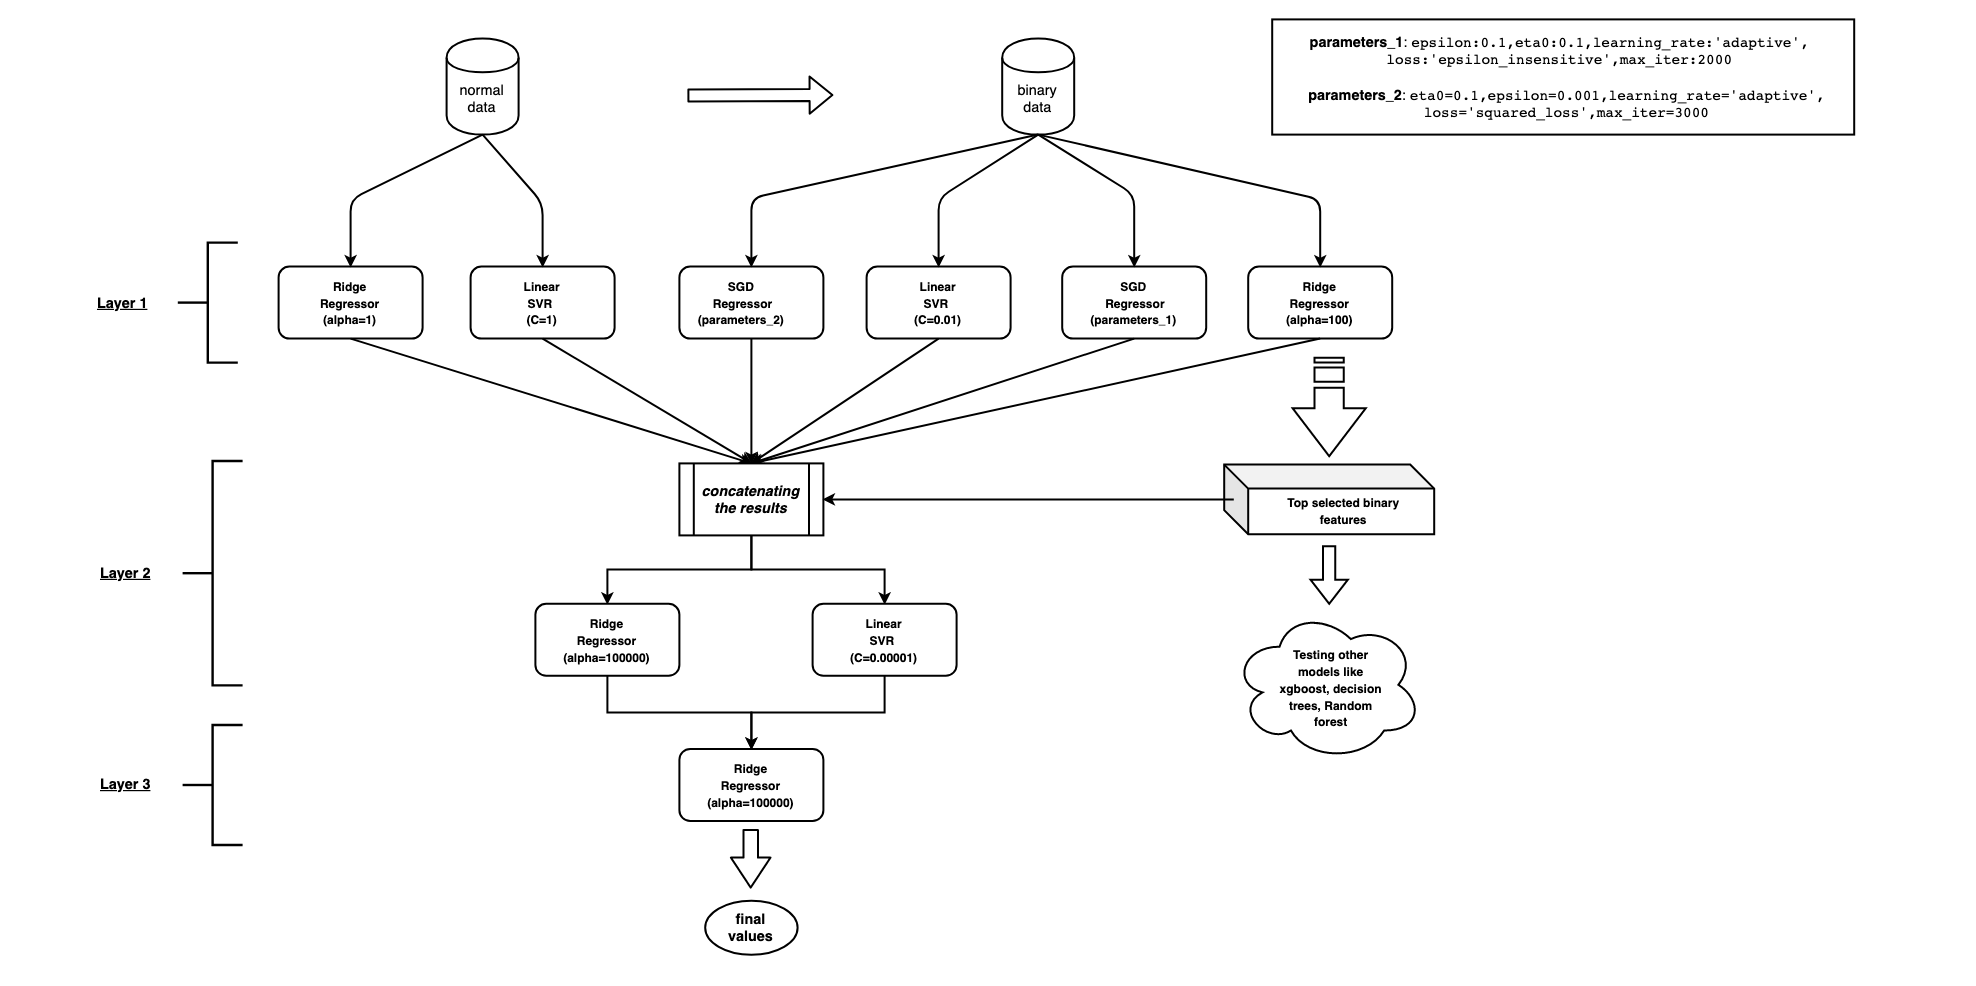

In [0]:
%matplotlib inline
from IPython.display import Image
Image('final.png', width=1600, height=650)

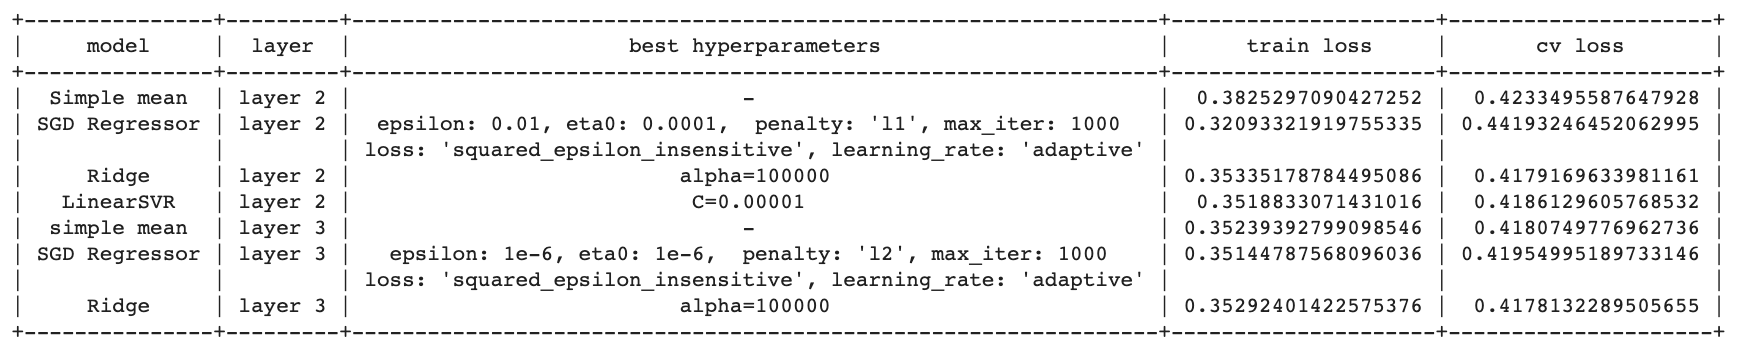

In [0]:
%matplotlib inline
from IPython.display import Image
Image('layer_2_table.png', width=1000, height=200)

#### Model saved weights on this link: https://drive.google.com/open?id=1-ow6oRzhUB7IuVRaJ-C2IA3nMPCmCMko

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer as Tfidf
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from scipy import sparse
from time import time
import pandas as pd
import numpy as np
import joblib

In [0]:
def final_fun_1(x):
  path = 'drive/My Drive/marcari_kaggle_data/output'
  print('cleaning data...')
  try:
    x = x[x['price'] > 0].reset_index(drop=True) # dropping the rows with price=0
  except:
    pass
  # collecting data ########################
  x['name'] = x['name'].fillna('') + ' ' + x['brand_name'].fillna('')
  x['text'] = (x['item_description'].fillna('') + ' ' + x['name'] + ' ' + x['category_name'].fillna('')) # Creating text features by concatenation.
  x = x[['name', 'text', 'shipping', 'item_condition_id']]

  # vectorizing text data ########################
  print('processing tfidf...')
  tfidf_name = joblib.load(f'{path}/tfidf_name.sav')
  tfidf_text = joblib.load(f'{path}/tfidf_text.sav')
  # Joining all the processed features
  x = sparse.hstack((tfidf_name.transform(x['name']), sparse.csr_matrix(x['shipping'].values.reshape(-1,1)), 
                      tfidf_text.transform(x['text']), sparse.csr_matrix(x['item_condition_id'].values.reshape(-1,1) - 1.))).tocsr()

  del tfidf_name
  del tfidf_text
  # creating the binary equivallent
  x_binary = x.astype(np.bool).astype(np.float32)

  # layer 1 models ########################
  print('collecting results from layer 1 models...')
  # Ridge regressor on normal data
  regressor = joblib.load(f'{path}/ridge_normal_l1.sav')
  result = regressor.predict(x).reshape(-1,1)
  # Ridge regressor on binary data
  regressor = joblib.load(f'{path}/ridge_binary_l1.sav')
  result = np.concatenate((result, regressor.predict(x_binary).reshape(-1,1)), axis=1)
  # SGD regressor as SVR on binary data
  regressor = joblib.load(f'{path}/sgd_svr_binary_l1.sav')
  result = np.concatenate((result, regressor.predict(x_binary).reshape(-1,1)), axis=1)
  # SGD regressor as LR on binary data
  regressor = joblib.load(f'{path}/sgd_lr_binary_l1.sav')
  result = np.concatenate((result, regressor.predict(x_binary).reshape(-1,1)), axis=1)
  # Linear-SVR on normal data
  regressor = joblib.load(f'{path}/svr_normal_l1.sav')
  result = np.concatenate((result, regressor.predict(x).reshape(-1,1)), axis=1)
  # Linear-SVR on binary data
  regressor = joblib.load(f'{path}/svr_binary_l1.sav')
  result = np.concatenate((result, regressor.predict(x_binary).reshape(-1,1)), axis=1)

  print('creating top features and joining them...')
  # Selecting top features from binary data using Ridge regressor.
  selection = joblib.load(f'{path}/top_selector.sav')
  x_binary = selection.transform(x_binary) # These are the top features, but I'm storing them in x_binary because that variable is vaccant.

  x = sparse.hstack((x_binary, sparse.csr_matrix(result)))
  del x_binary
  # Layer 2 models ########################
  print('ensembling now...')
  # Ridge regressor on data from layer_1 + top features
  regressor = joblib.load(f'{path}/ridge_l2.sav')
  result = regressor.predict(x).reshape(-1,1)
  # Linear SVR on data from layer_1 + top features
  regressor = joblib.load(f'{path}/linearsvr_l2.sav')
  x = np.concatenate((result, regressor.predict(x).reshape(-1,1)), axis=1)
  # Final layer Ridge regressor model ########################
  regressor = joblib.load(f'{path}/ridge_l3.sav')
  result = regressor.predict(x)
  # Converting result back to it's default scale
  y_scaler = joblib.load(f'{path}/y_scaler.sav')

  return np.expm1(y_scaler.inverse_transform(result.reshape(-1, 1))[:, 0])

In [0]:
from sklearn.metrics import mean_squared_log_error
def final_fun_2(x,y):
  y_pred = final_fun_1(x).price.values.reshape(1,-1)
  return mean_squared_log_error(y_pred, y.reshape(1,-1))

In [17]:
start_time = time()
x = pd.read_table('test_stg2.tsv')
y_pred = final_fun_1(x)
(time() - start_time)/60

cleaning data...
processing tfidf...
collecting results from layer 1 models...
creating top features and joining them...
ensembling now...


9.142643857002259

In [22]:
x = pd.read_table('drive/My Drive/marcari_kaggle_data/train.tsv')
x = x[x['price']>0].reset_index(drop=True)
y = x.price.values
final_fun_2(x,y)

cleaning data...
processing tfidf...
collecting results from layer 1 models...
creating top features and joining them...
ensembling now...


0.12063691239641272

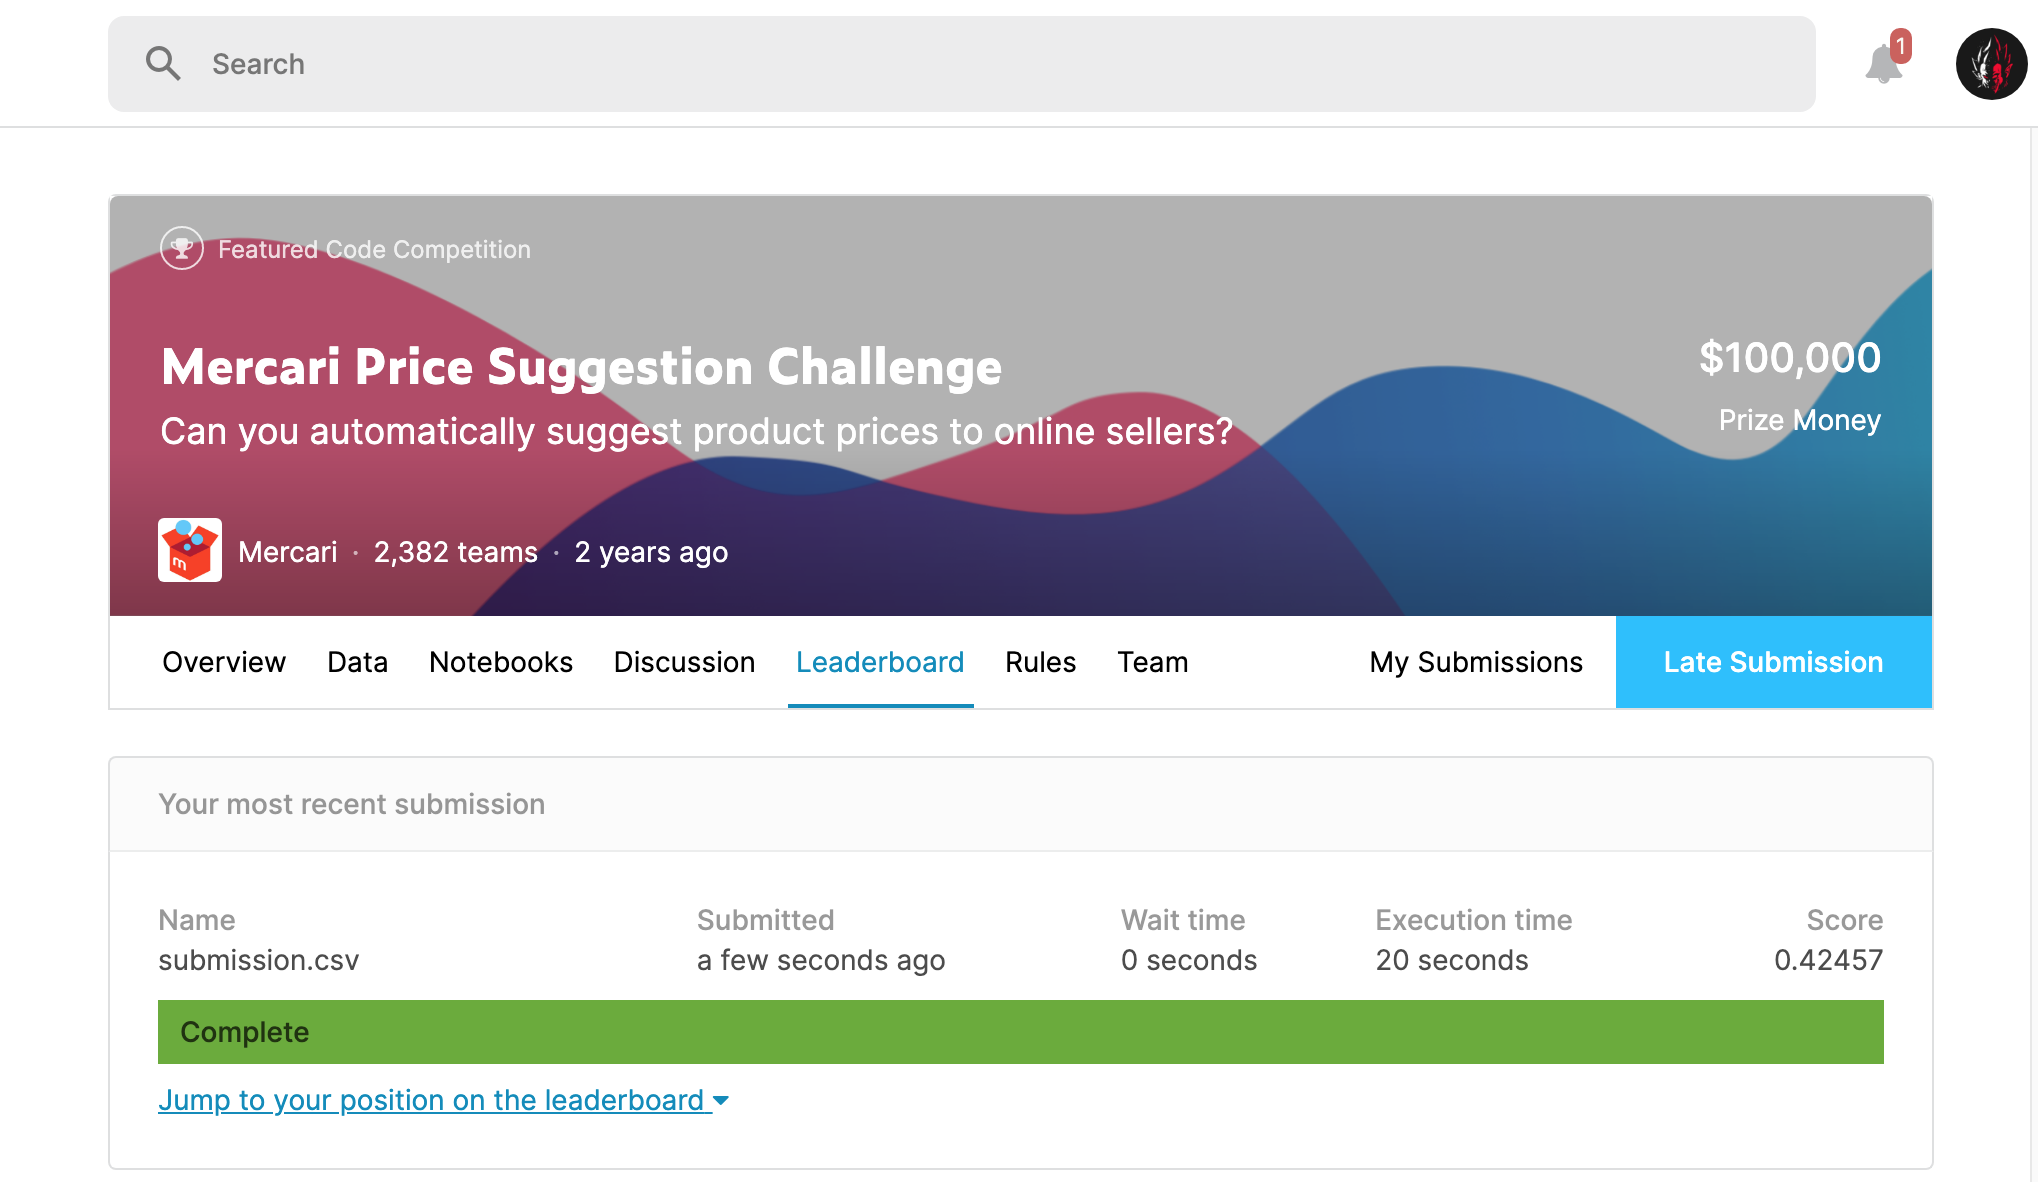

In [26]:
%matplotlib inline
from IPython.display import Image
Image('top.png', width=1200, height=700)

### Using the above modelling architecture, I was able to achieve a score in top 6%